In [2]:
#@title Connect to gdrive
import google.colab.drive
google.colab.drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
#@title Load the precomputed centrality measures
import pandas as pd
# Load the CSV file into a DataFrame
input_csv_file = "/content/drive/MyDrive/network_science/group_project_deezer/node_data_RO_v2.csv"
df_nodes = pd.read_csv(input_csv_file)

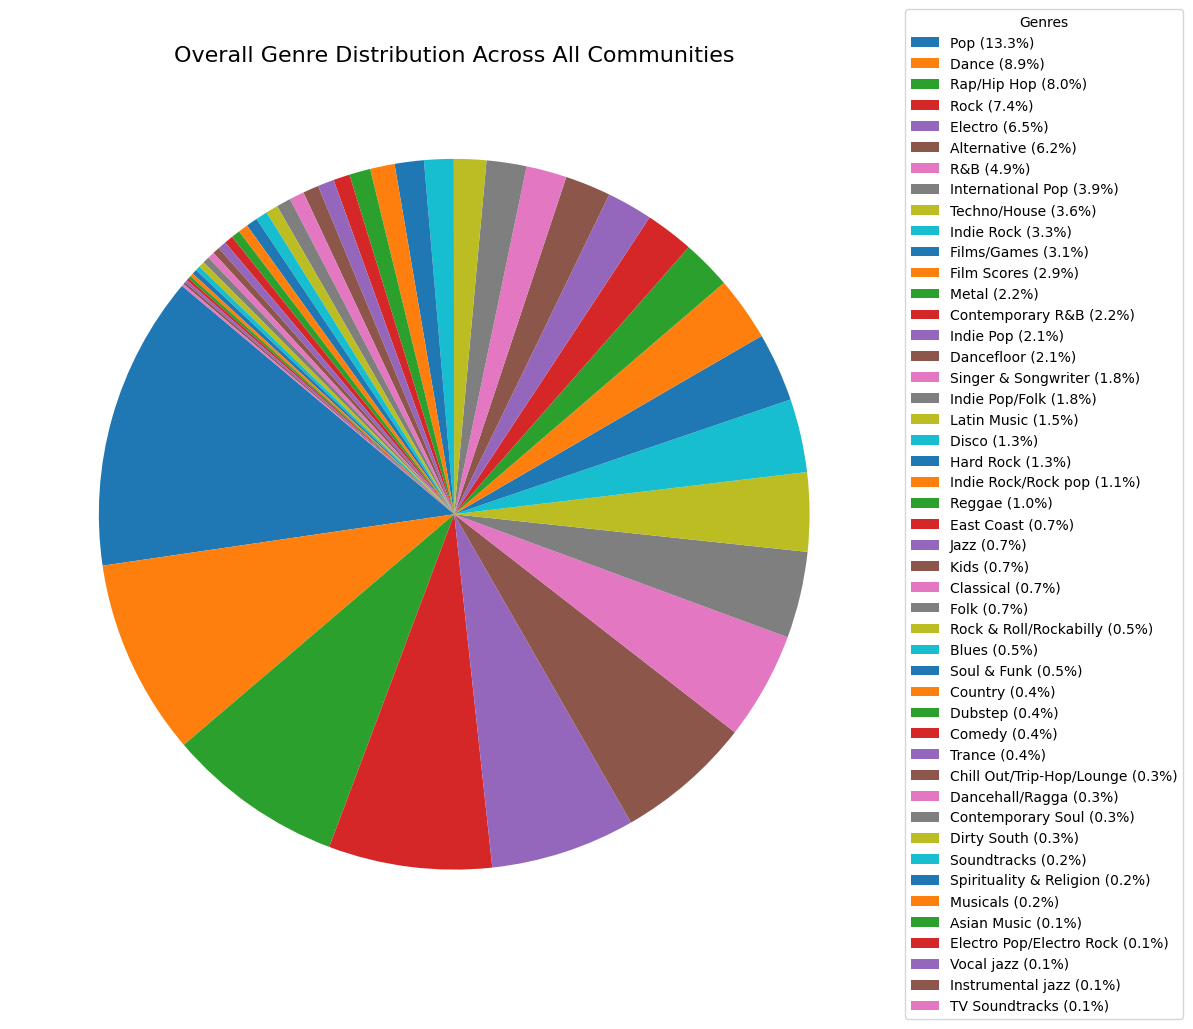

In [4]:
#@title Overall genre distribution
from collections import Counter
import matplotlib.pyplot as plt

# Extract genres from the DataFrame
all_genres = []
for genres in df_nodes['genres']:
    all_genres.extend(eval(genres))  # Convert stringified list to actual list and extend the genre list

# Count genre occurrences
overall_genre_count = Counter(all_genres)

# Calculate total count for percentages
total_count = sum(overall_genre_count.values())

# Filter genres with percentages >= 0.1% and sort them by percentage descending
filtered_genres = {
    genre: count for genre, count in overall_genre_count.items()
    if (count / total_count * 100) >= 0.1
}
sorted_genres = sorted(
    filtered_genres.items(),
    key=lambda x: x[1] / total_count,
    reverse=True
)

# Create labels with percentages for the legend
labels_with_percentages = [
    f"{genre} ({count / total_count * 100:.1f}%)"
    for genre, count in sorted_genres
]

# Get the sorted values for the pie chart
values = [count for _, count in sorted_genres]

# Plot pie chart without labels directly on the chart
plt.figure(figsize=(12, 12))  # Adjust figure size for better spacing
wedges, texts = plt.pie(
    values,
    labels=None,  # No labels directly on the chart
    startangle=140,
    textprops={'fontsize': 10}
)

# Add a legend with genre labels and percentages
plt.legend(
    wedges,
    labels_with_percentages,
    title="Genres",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=10
)

# Add chart title
plt.title("Overall Genre Distribution Across All Communities", fontsize=16)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


##Insights

The genres with the largest slices in the pie chart—Pop (13.3%), Dance (8.9%), and Rap/Hip Hop (8.0%)—indicate that they are likely central within user communities. These genres have strong intra-community connections, as they dominate user preferences.
Rock (7.4%), Electro (6.5%), and Alternative (6.2%) also show significant presence, suggesting that they might form the core around which specific communities are built.

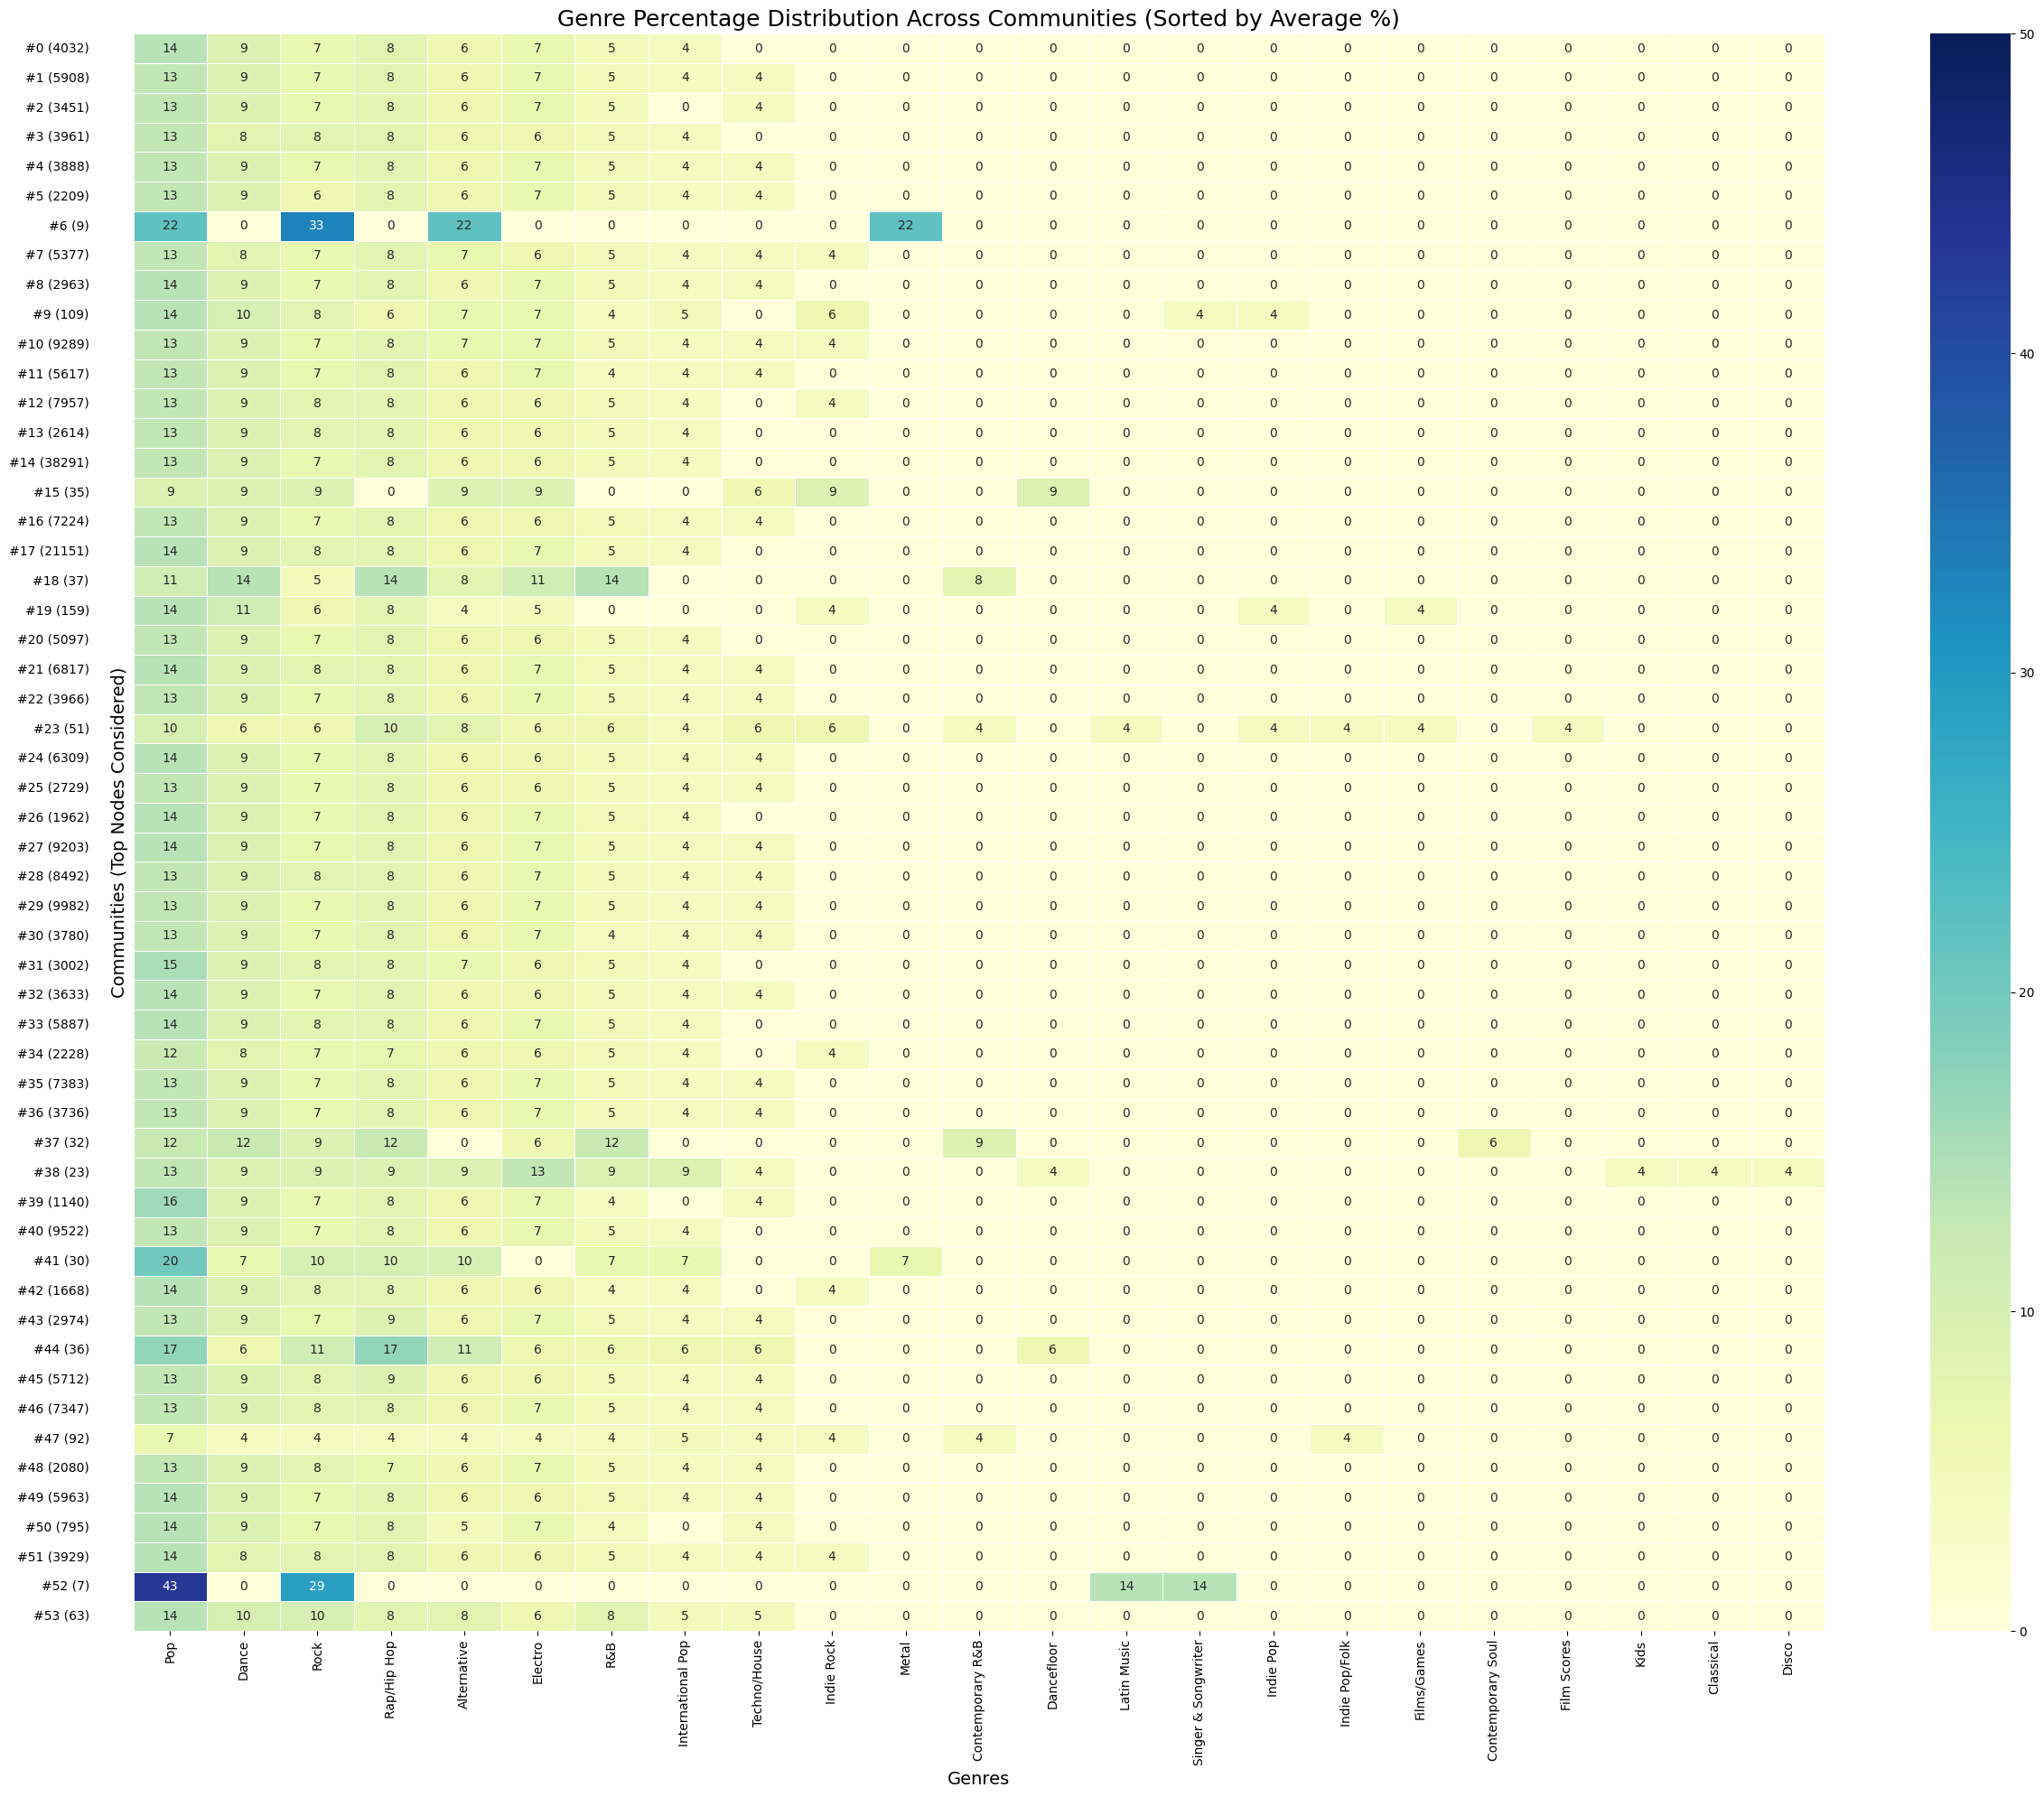

In [5]:
#@title Heatmap for Genre distributions across communities by percentage

from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group nodes by community
grouped = df_nodes.groupby('community_id')

# Initialize the central_genres dictionary
central_genres = {}

# Compute genre distributions for each community
for community_id, group in grouped:
    # Flatten the genres for the entire community
    genres = [genre for genre_list in group['genres'] for genre in eval(genre_list)]
    genre_count = Counter(genres)
    total_genres = sum(genre_count.values())

    # Compute percentages and store in central_genres
    central_genres[community_id] = [
        {
            "genre": genre,
            "count": count,
            "percentage": (count / total_genres) * 100,
            "total": total_genres
        }
        for genre, count in genre_count.items()
    ]


# Preparing data for heatmap
data = []
min_percentage_threshold = 3  # Minimum percentage threshold to display genres

for community, genres in central_genres.items():
    row = {"Community": f"#{community}"}  # Community ID for the y-axis
    row["Size"] = genres[0]["total"] if genres else 0  # Total size of the community
    if genres:
        for genre in genres:
            percentage = round(genre["percentage"])
            if percentage > min_percentage_threshold:  # Filter genres with > 1%
                row[genre["genre"]] = percentage
    data.append(row)

# Create a DataFrame for heatmap
heatmap_df = pd.DataFrame(data).fillna(0).set_index("Community")

# Remove columns with all zeros (genres not meeting thresholds)
heatmap_df = heatmap_df.loc[:, (heatmap_df != 0).any(axis=0)]

# Calculate the average percentage for each genre and sort columns
average_genre_percentages = heatmap_df.mean().sort_values(ascending=False)
heatmap_df = heatmap_df[average_genre_percentages.index]

# Extract community sizes for annotations
community_sizes = heatmap_df.pop("Size")

# Plot the heatmap
plt.figure(figsize=(25, 20))  # Extended horizontal size for better readability
sns.heatmap(
    heatmap_df,
    cmap="YlGnBu",
    annot=True,
    fmt=".0f",  # Display rounded integer values
    linewidths=0.5,
    cbar=True,
    vmin=0,  # Minimum value for color scale
    vmax=50,  # Maximum value for color scale (adjust as needed for clarity)
    yticklabels=False  # Disable default y-axis tick labels
)

# Add title and axis labels
plt.title("Genre Percentage Distribution Across Communities (Sorted by Average %)", fontsize=18)
plt.xlabel("Genres", fontsize=14)
plt.ylabel("Communities (Top Nodes Considered)", fontsize=14)

# Add community sizes as annotations on the y-axis
ax = plt.gca()  # Get current axis
y_ticks = range(len(heatmap_df.index))  # Generate y-ticks manually
for y_tick, community, size in zip(y_ticks, heatmap_df.index, community_sizes):
    plt.text(
        x=-0.6,  # Adjust text position
        y=y_tick + 0.5,  # Slight adjustment to center the text
        s=f"{community} ({size})",  # Community ID and size
        ha="right",
        va="center",
        fontsize=10,
        color="black"
    )

plt.tight_layout()  # Ensure the layout fits well
plt.show()


## Insights:

Pop emerges as the most dominant genre across all communities. This is evident from its consistent high percentage (up to 14%) across nearly every community, suggesting that it plays a central role in uniting users within and across communities.
Dance, Rock, and Rap/Hip Hop are other prominent genres with moderate to high percentages, indicating their widespread appeal across multiple communities.

This also suggest the homogenity of these communities, where majority share the same percentage in genre distribution. This might indicate that for majority communities the correlation between genre of interest and friendhsips (the node connections) is statistically insignificant. Only few small communities have very specifc domination of niche genres (e.g. #6 with Rock and Metal dominating).



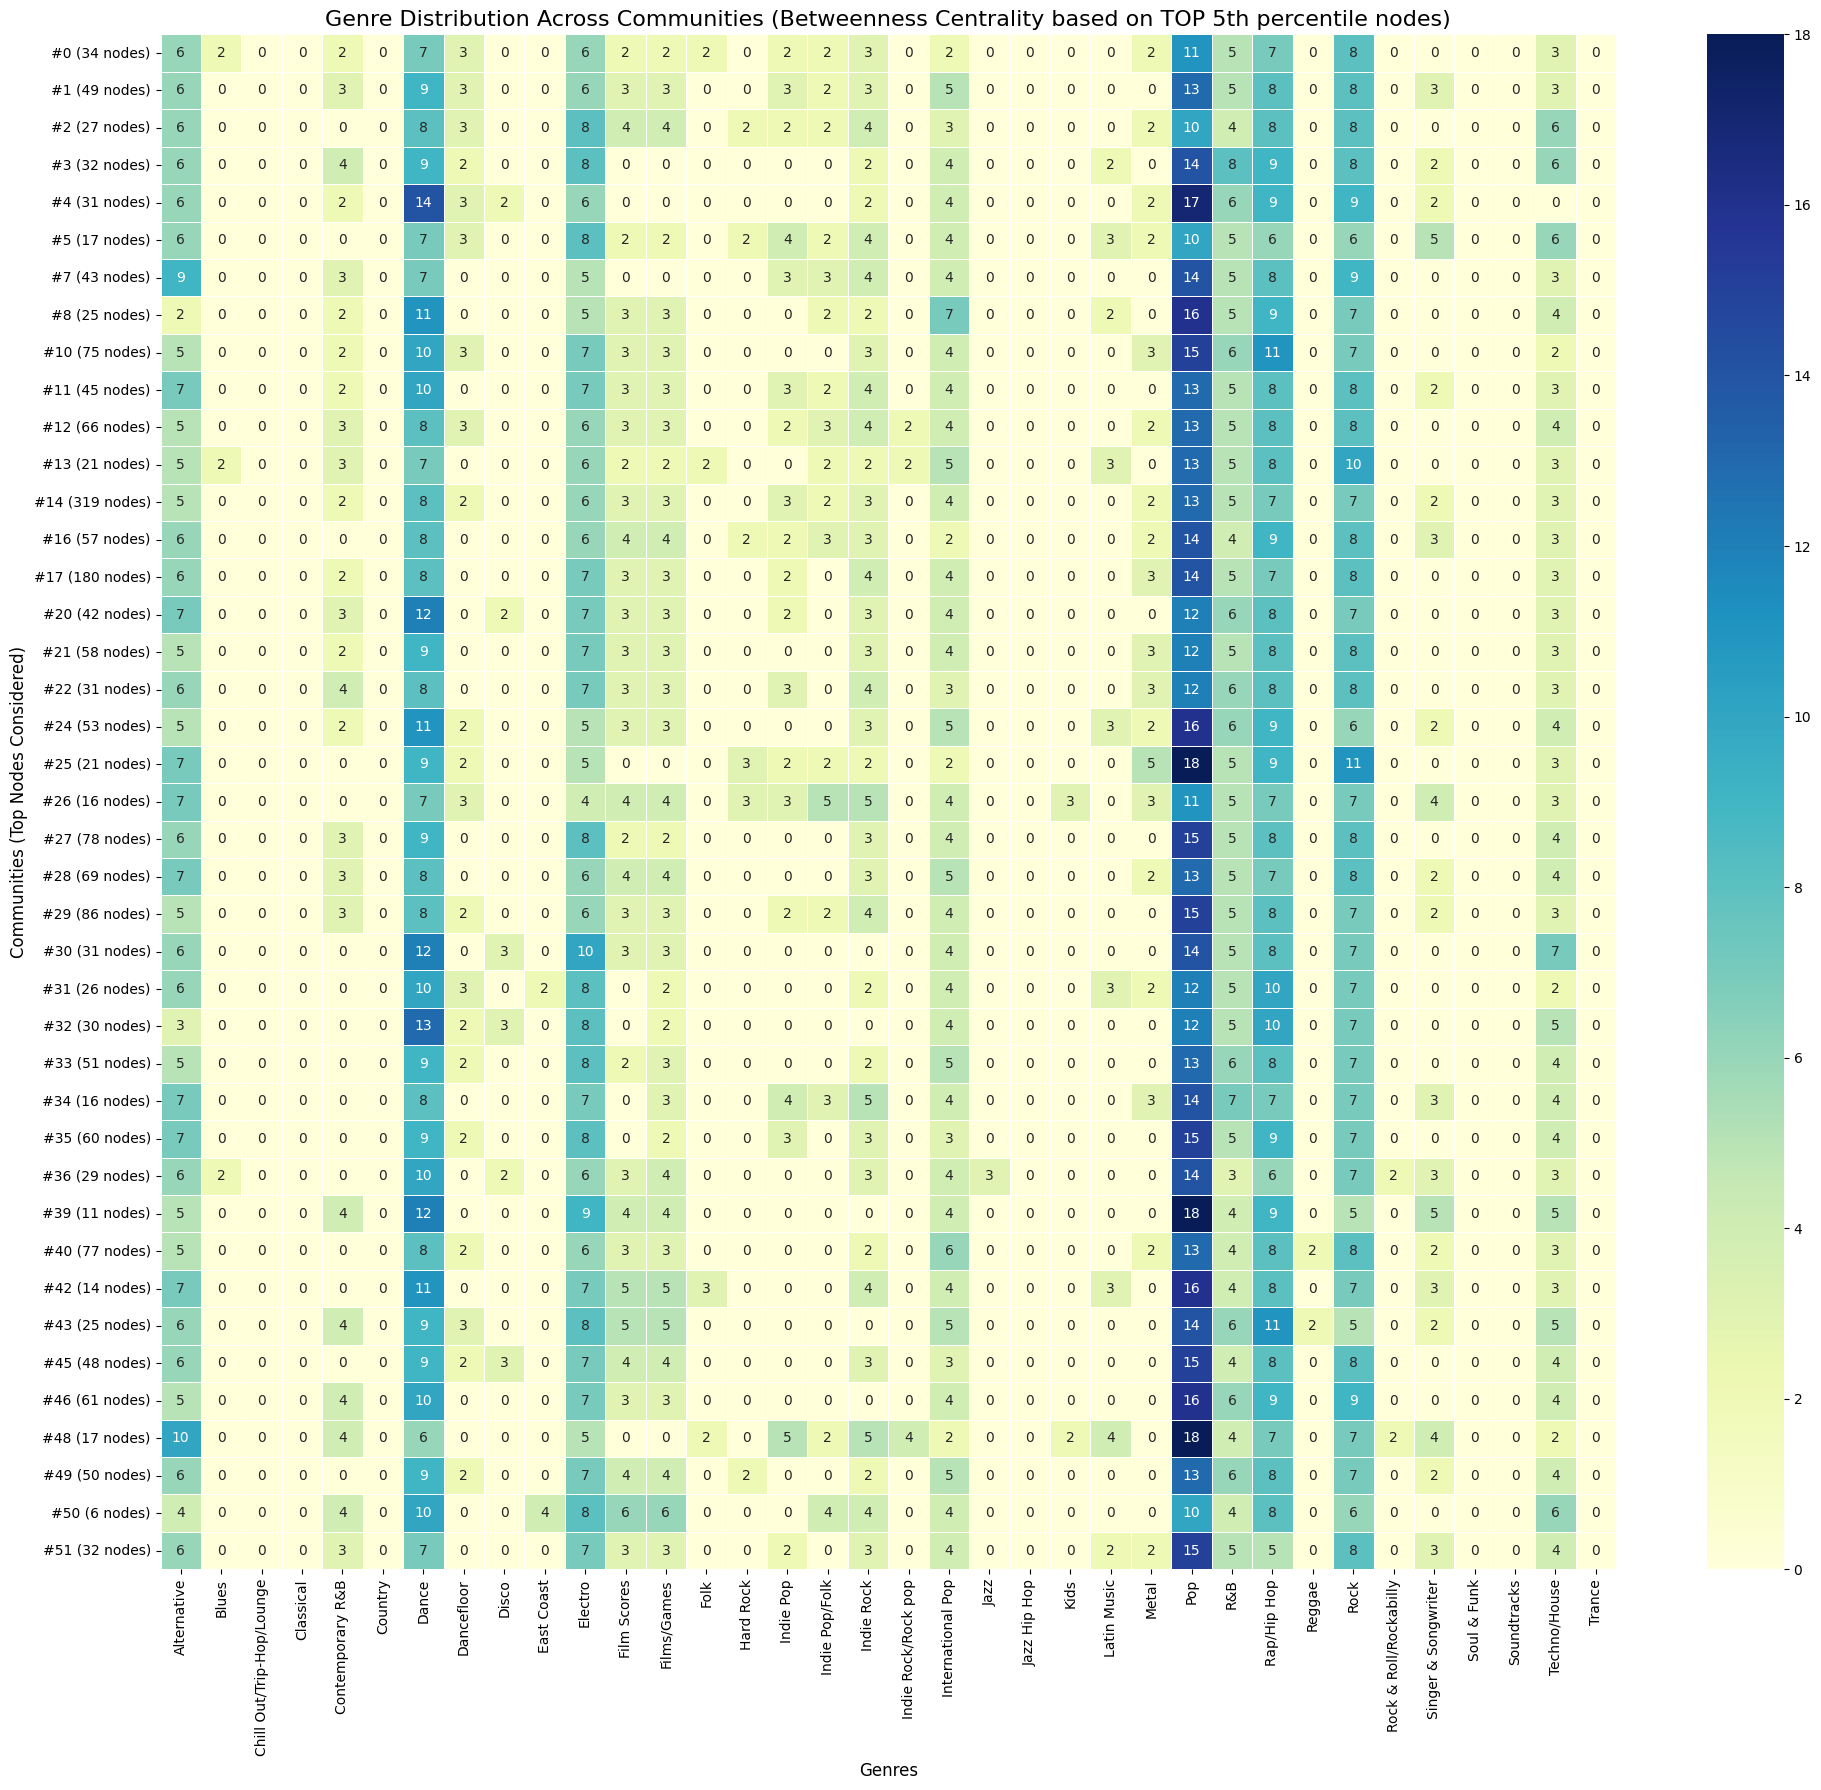

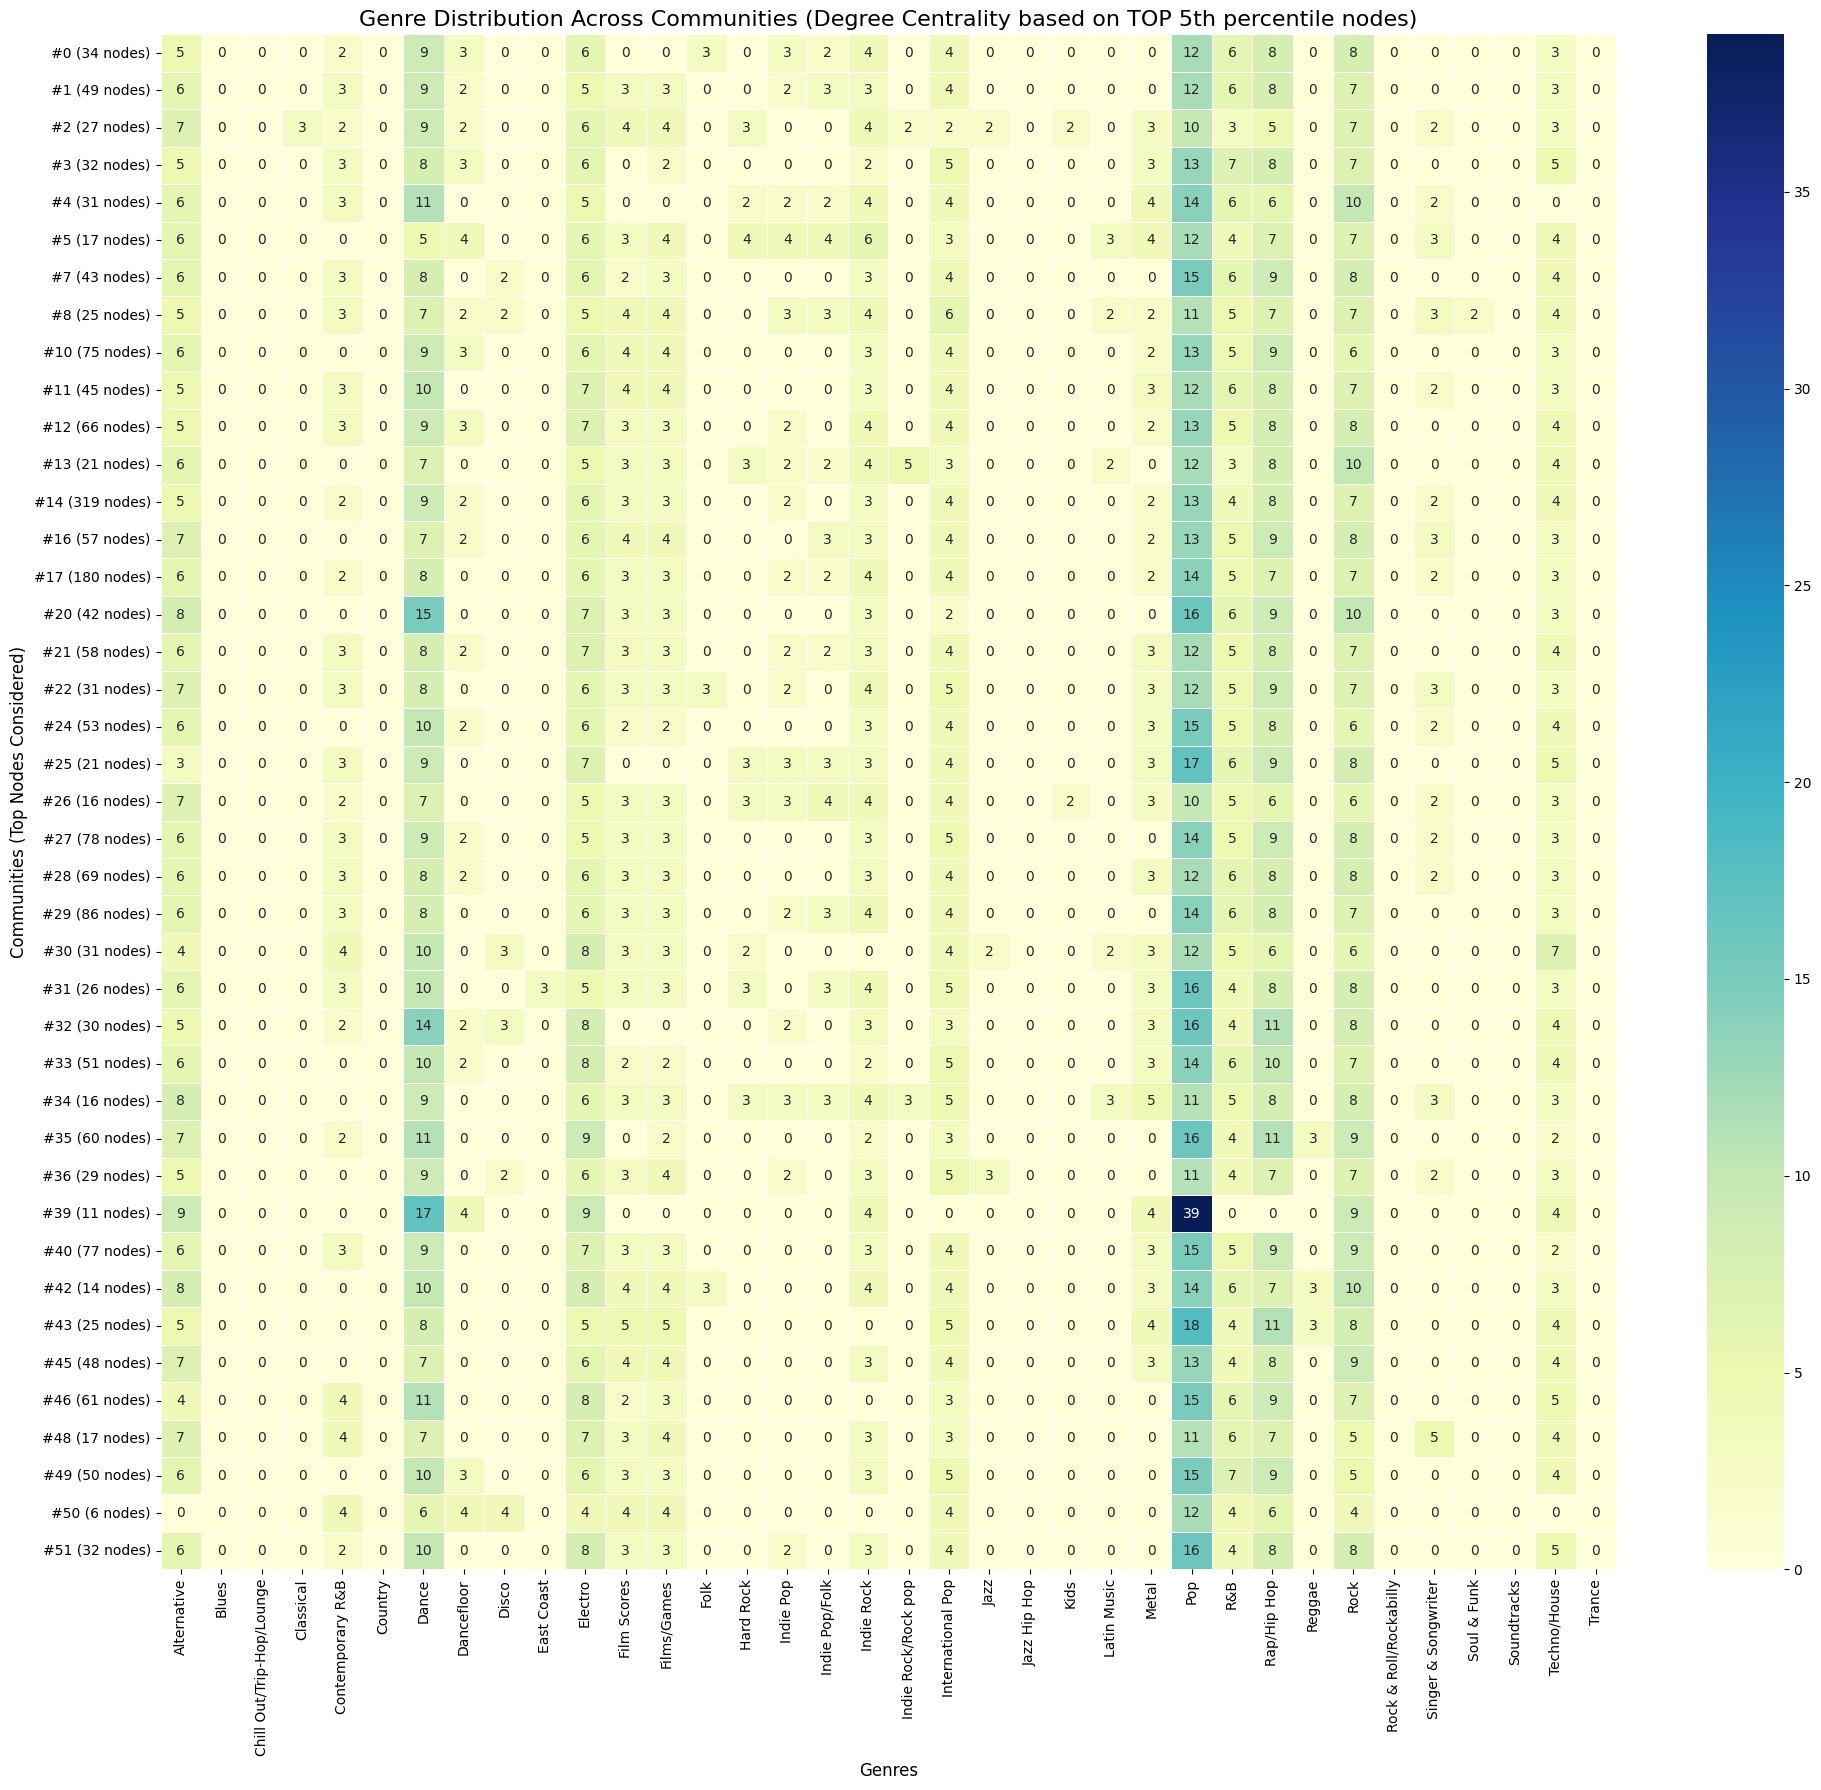

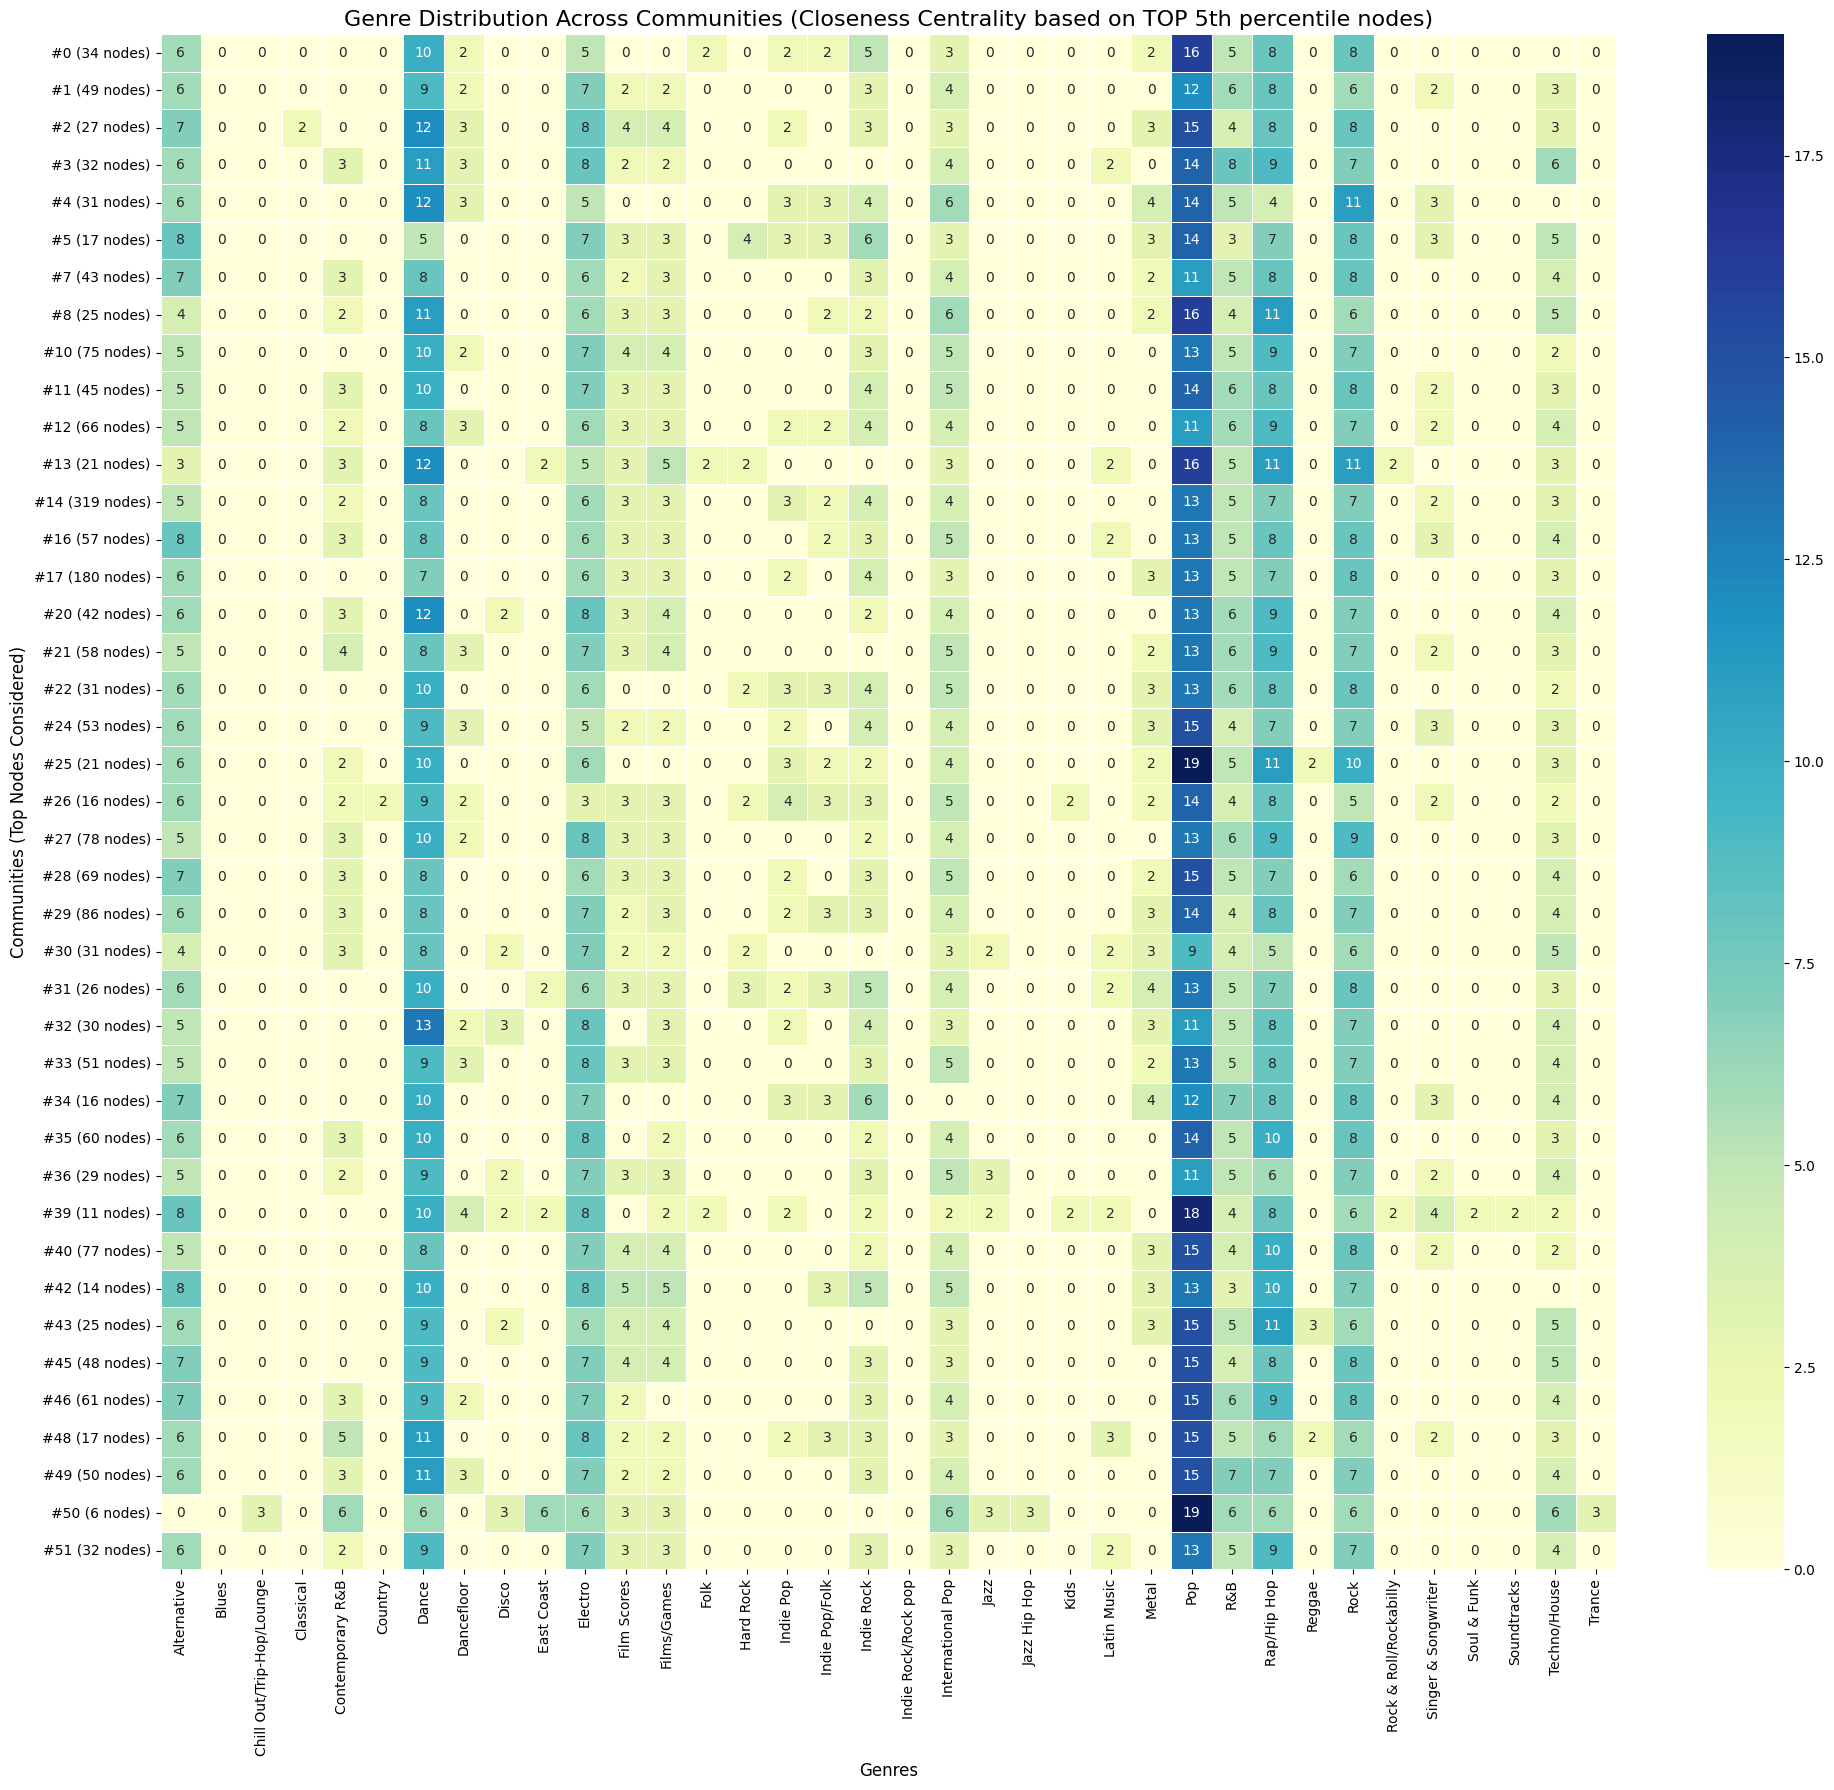

In [10]:
#@title Genre distribution across communities for different centrality measures (top 5th percentile users)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Define the percentile cutoff (top 5%)
percentile_cutoff = 0.05
min_percentage_threshold = 2  # Minimum percentage to display

# Group nodes by community
grouped = df_nodes.groupby('community_id')

# Filter out communities with only a single node
filtered_grouped = {community_id: group for community_id, group in grouped if len(group) > 1}

# Initialize a dictionary to store results
centrality_genre_aggregation = {"betweenness": {}, "degree": {}, "closeness": {}}

for community_id, group in filtered_grouped.items():
    community_size = group['community_size'].iloc[0]  # Community size is constant within each group

    # Determine the cutoff for top percentile nodes
    top_percentile_count = max(1, int(len(group) * percentile_cutoff))  # At least 1 node
    if top_percentile_count < 2:
      continue

    # Sort by each centrality measure
    sorted_by_betweenness = group.sort_values(by='betweenness_centrality', ascending=False)
    sorted_by_degree = group.sort_values(by='degree_centrality', ascending=False)
    sorted_by_closeness = group.sort_values(by='closeness_centrality', ascending=False)

    # Select top percentile nodes for each centrality measure
    top_betweenness = sorted_by_betweenness.head(top_percentile_count)
    top_degree = sorted_by_degree.head(top_percentile_count)
    top_closeness = sorted_by_closeness.head(top_percentile_count)

    # Aggregate genres for each centrality measure
    for measure, top_nodes in [("betweenness", top_betweenness), ("degree", top_degree), ("closeness", top_closeness)]:
        genres = [genre for genres in top_nodes['genres'] for genre in eval(genres)]
        genre_count = Counter(genres)
        total_genres = sum(genre_count.values())
        genre_percentage = {
            genre: (count / total_genres) * 100
            for genre, count in genre_count.items()
            if (count / total_genres) * 100 >= min_percentage_threshold  # Apply minimum percentage filter
        }
        centrality_genre_aggregation[measure][f"#{community_id} ({top_percentile_count} nodes)"] = genre_percentage

# Get the union of all unique genres across measures
all_genres = set()
for measure_data in centrality_genre_aggregation.values():
    for genre_percentages in measure_data.values():
        all_genres.update(genre_percentages.keys())

# Convert results into DataFrames for heatmaps with consistent genre order
sorted_genres = sorted(all_genres)  # Sort genres alphabetically or based on any criterion
heatmap_data = {}
for measure, communities in centrality_genre_aggregation.items():
    rows = []
    for community_id, genre_percentages in communities.items():
        row = {"Community": community_id}
        row.update({genre: round(genre_percentages.get(genre, 0)) for genre in sorted_genres})
        rows.append(row)
    df = pd.DataFrame(rows).fillna(0).set_index("Community")
    heatmap_data[measure] = df

# Plot heatmaps for each centrality measure with consistent x-axis genre order
for measure, heatmap_df in heatmap_data.items():
    plt.figure(figsize=(20, 18))  # Larger horizontal size
    sns.heatmap(
        heatmap_df,
        cmap="YlGnBu",
        annot=True,
        fmt=".0f",
        linewidths=0.5,
        cbar=True
    )
    plt.title(f"Genre Distribution Across Communities ({measure.capitalize()} Centrality based on TOP 5th percentile nodes)", fontsize=16)
    plt.xlabel("Genres", fontsize=12)
    plt.ylabel("Communities (Top Nodes Considered)", fontsize=12)
    plt.tight_layout()
    plt.show()


## Insights

### Betweenness

Betweenness centrality measures how often a node (user) acts as a bridge on the shortest paths between other nodes. It highlights influential genres facilitating cross-community interactions.

Pop, Rap/Hip-Hop and Rock show consistently high values across many communities, indicating their role as a bridge genre that connects users across communities.

Techno/House and Electro are more pronounced in specific communities like #2 and #5, emphasizing their localized influence on cross-community connectivity.

Bridging genres like Pop, Rap/Hip Hop, and Techno/House may facilitate genre dissemination across diverse large communities.

### Degree

Degree centrality measures the number of direct connections a node has. Genres with high degree centrality are directly popular among users in a community.

Pop and Dance exhibit strong values across most communities, reaffirming their broad appeal and widespread popularity. However, the overall spread is more uniform compared to betweenness centrality.

There are some more-homogenous communities where a signle genre is dominating such as #39 with Pop or #20 with Dance.

Niche genres like Alternative and Electro show high degree centrality in smaller communities like #39, indicating that these genres are popular within specific subgroups which may signify subcultures within the network.

### Closeness

Closeness centrality measures how quickly a node can access all other nodes in the network. Genres with high closeness centrality are central to the community's connectivity.

Pop, Hip-Hop, Rock and Dance once again emerge as central genres across many communities, emphasizing their ease of access within networks.

However, there are more diverse communities such as #50 where other than these popular genres some niche ones emerge such as Contemporary R&B or East Coast










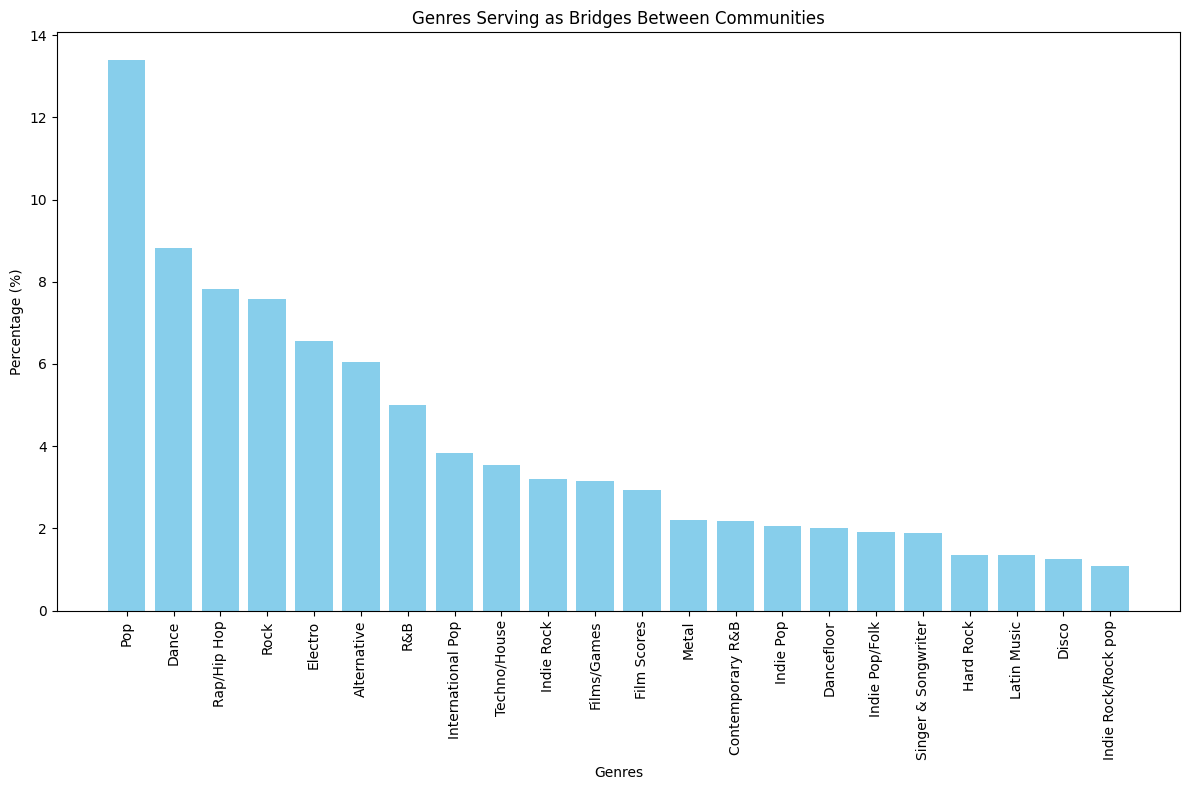

In [11]:
#@title find bridging nodes genre distribution

from collections import Counter
import matplotlib.pyplot as plt

# Select top 5% of nodes for betweenness centrality
top_percentile = 5
threshold = df_nodes['betweenness_centrality'].quantile(1 - top_percentile / 100)
top_nodes = df_nodes[df_nodes['betweenness_centrality'] >= threshold]

# Count genres
genre_counts = Counter()

for _, row in top_nodes.iterrows():
    genres = eval(row['genres'])  # Convert string representation of list to actual list
    genre_counts.update(genres)  # Update the Counter with individual genres

# Calculate percentages
total_genres = sum(genre_counts.values())
genre_percentages = {genre: (count / total_genres) * 100 for genre, count in genre_counts.items()}

# Filter and sort genres
filtered_genres = {genre: percentage for genre, percentage in genre_percentages.items() if percentage >= 1}
sorted_genres = dict(sorted(filtered_genres.items(), key=lambda x: x[1], reverse=True))  # Sort by percentage (descending)

# Plot the bar chart
plt.figure(figsize=(12, 8))
plt.bar(sorted_genres.keys(), sorted_genres.values(), color="skyblue")
plt.xticks(rotation=90)
plt.title("Genres Serving as Bridges Between Communities")
plt.ylabel("Percentage (%)")
plt.xlabel("Genres")
plt.tight_layout()
plt.show()

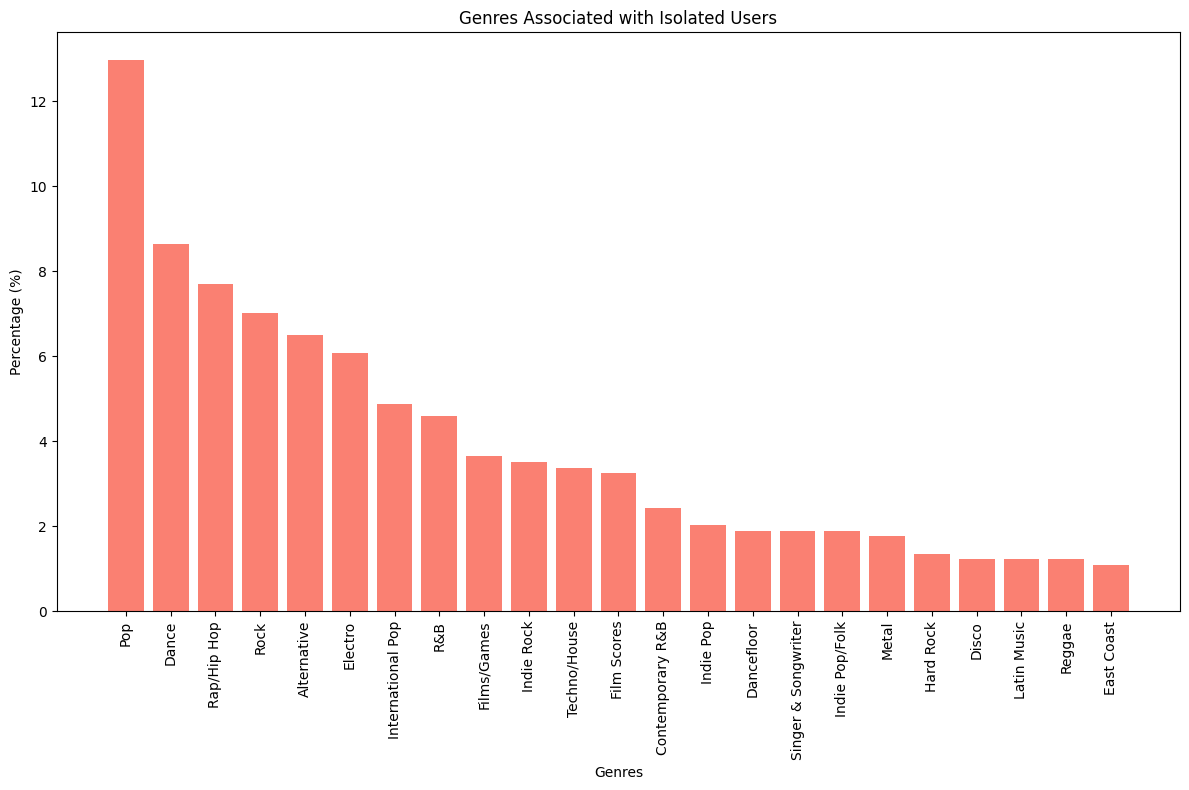

In [13]:
#@title Genres Associated with Isolated Users

from collections import Counter
import matplotlib.pyplot as plt

low_percentile = 5
low_degree_threshold = df_nodes['degree_centrality'].quantile(low_percentile / 100)
low_closeness_threshold = df_nodes['closeness_centrality'].quantile(low_percentile / 100)
low_betweenness_threshold = df_nodes['betweenness_centrality'].quantile(low_percentile / 100)

# Filter nodes with low centrality
isolated_nodes = df_nodes[
    (df_nodes['degree_centrality'] <= low_degree_threshold) &
    (df_nodes['closeness_centrality'] <= low_closeness_threshold) &
    (df_nodes['betweenness_centrality'] <= low_betweenness_threshold)
]

isolated_genre_counts = Counter()

for _, row in isolated_nodes.iterrows():
    genres = eval(row['genres'])  # Convert string representation of list to actual list
    isolated_genre_counts.update(genres)

# Calculate percentages
total_isolated_genres = sum(isolated_genre_counts.values())
isolated_genre_percentages = {
    genre: (count / total_isolated_genres) * 100
    for genre, count in isolated_genre_counts.items()
}

# Filter genres with >= 1% representation
filtered_isolated_genres = {
    genre: percentage
    for genre, percentage in isolated_genre_percentages.items()
    if percentage >= 1
}

# Sort genres by percentage
sorted_genres = dict(sorted(filtered_isolated_genres.items(), key=lambda x: x[1], reverse=True))

# Plot
plt.figure(figsize=(12, 8))
plt.bar(sorted_genres.keys(), sorted_genres.values(), color="salmon")
plt.xticks(rotation=90)
plt.title("Genres Associated with Isolated Users")
plt.ylabel("Percentage (%)")
plt.xlabel("Genres")
plt.tight_layout()
plt.show()


## Insights

This doesn't really differ from bridging genres, which suggests that genre might have very little impact on how the connections between nodes are formed, meaning, in aggregate for the entire network, they do not matter. However, for some smaller communities they might, so let's look into distribution by different communities.

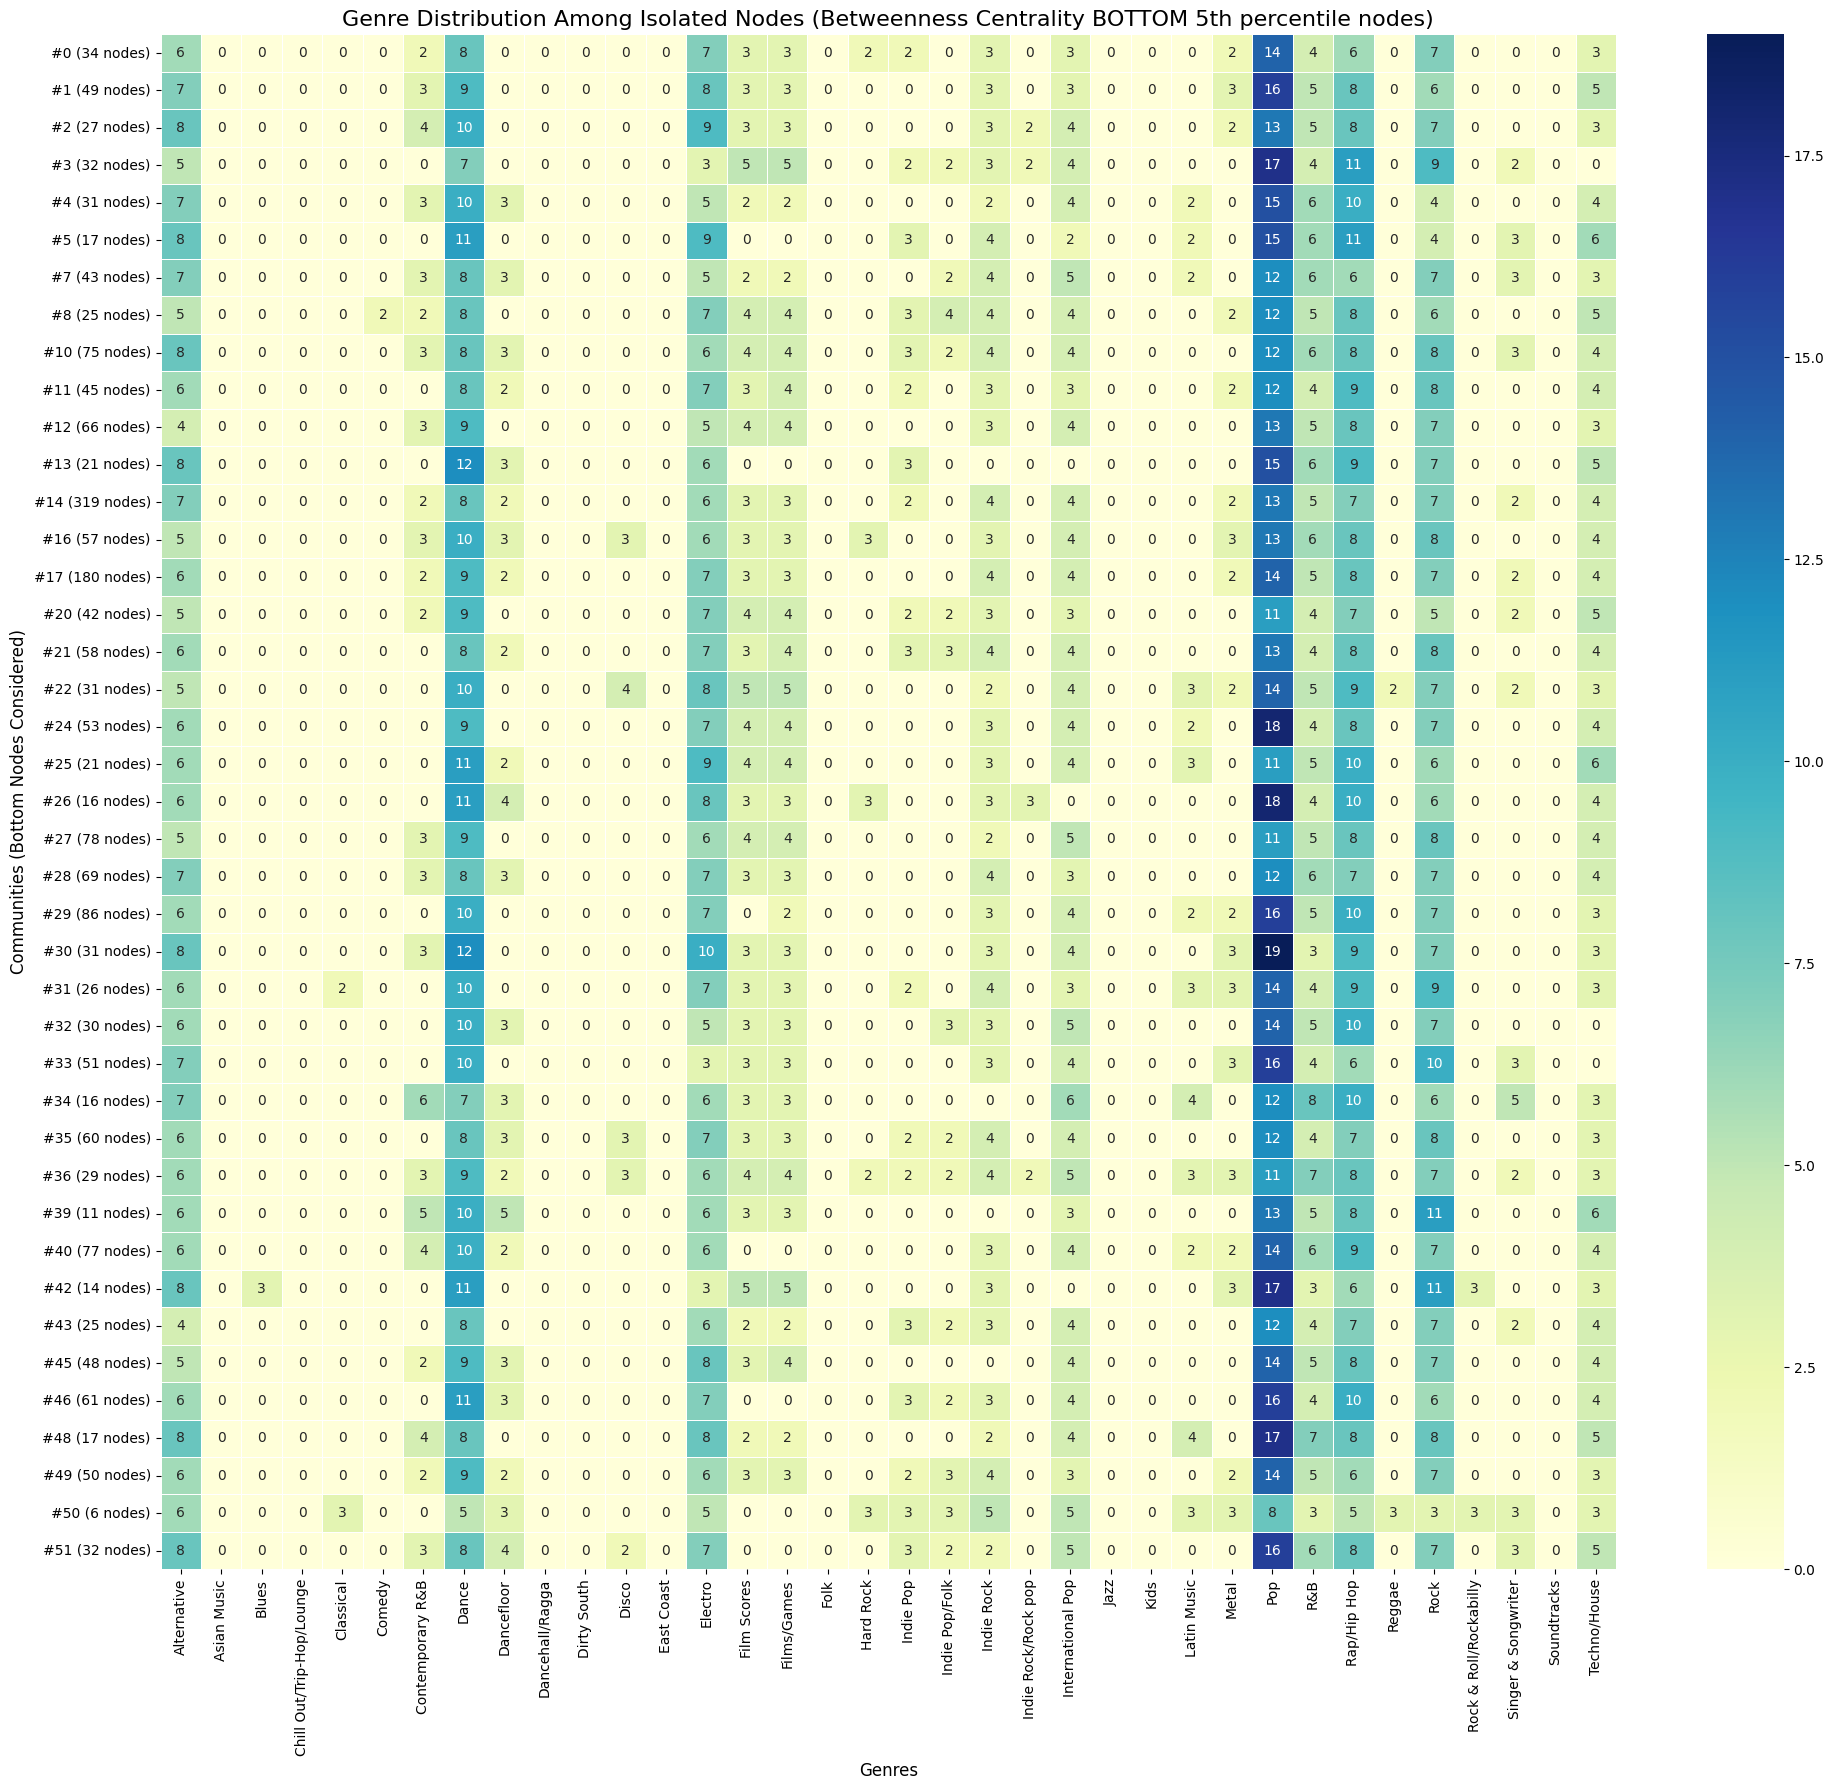

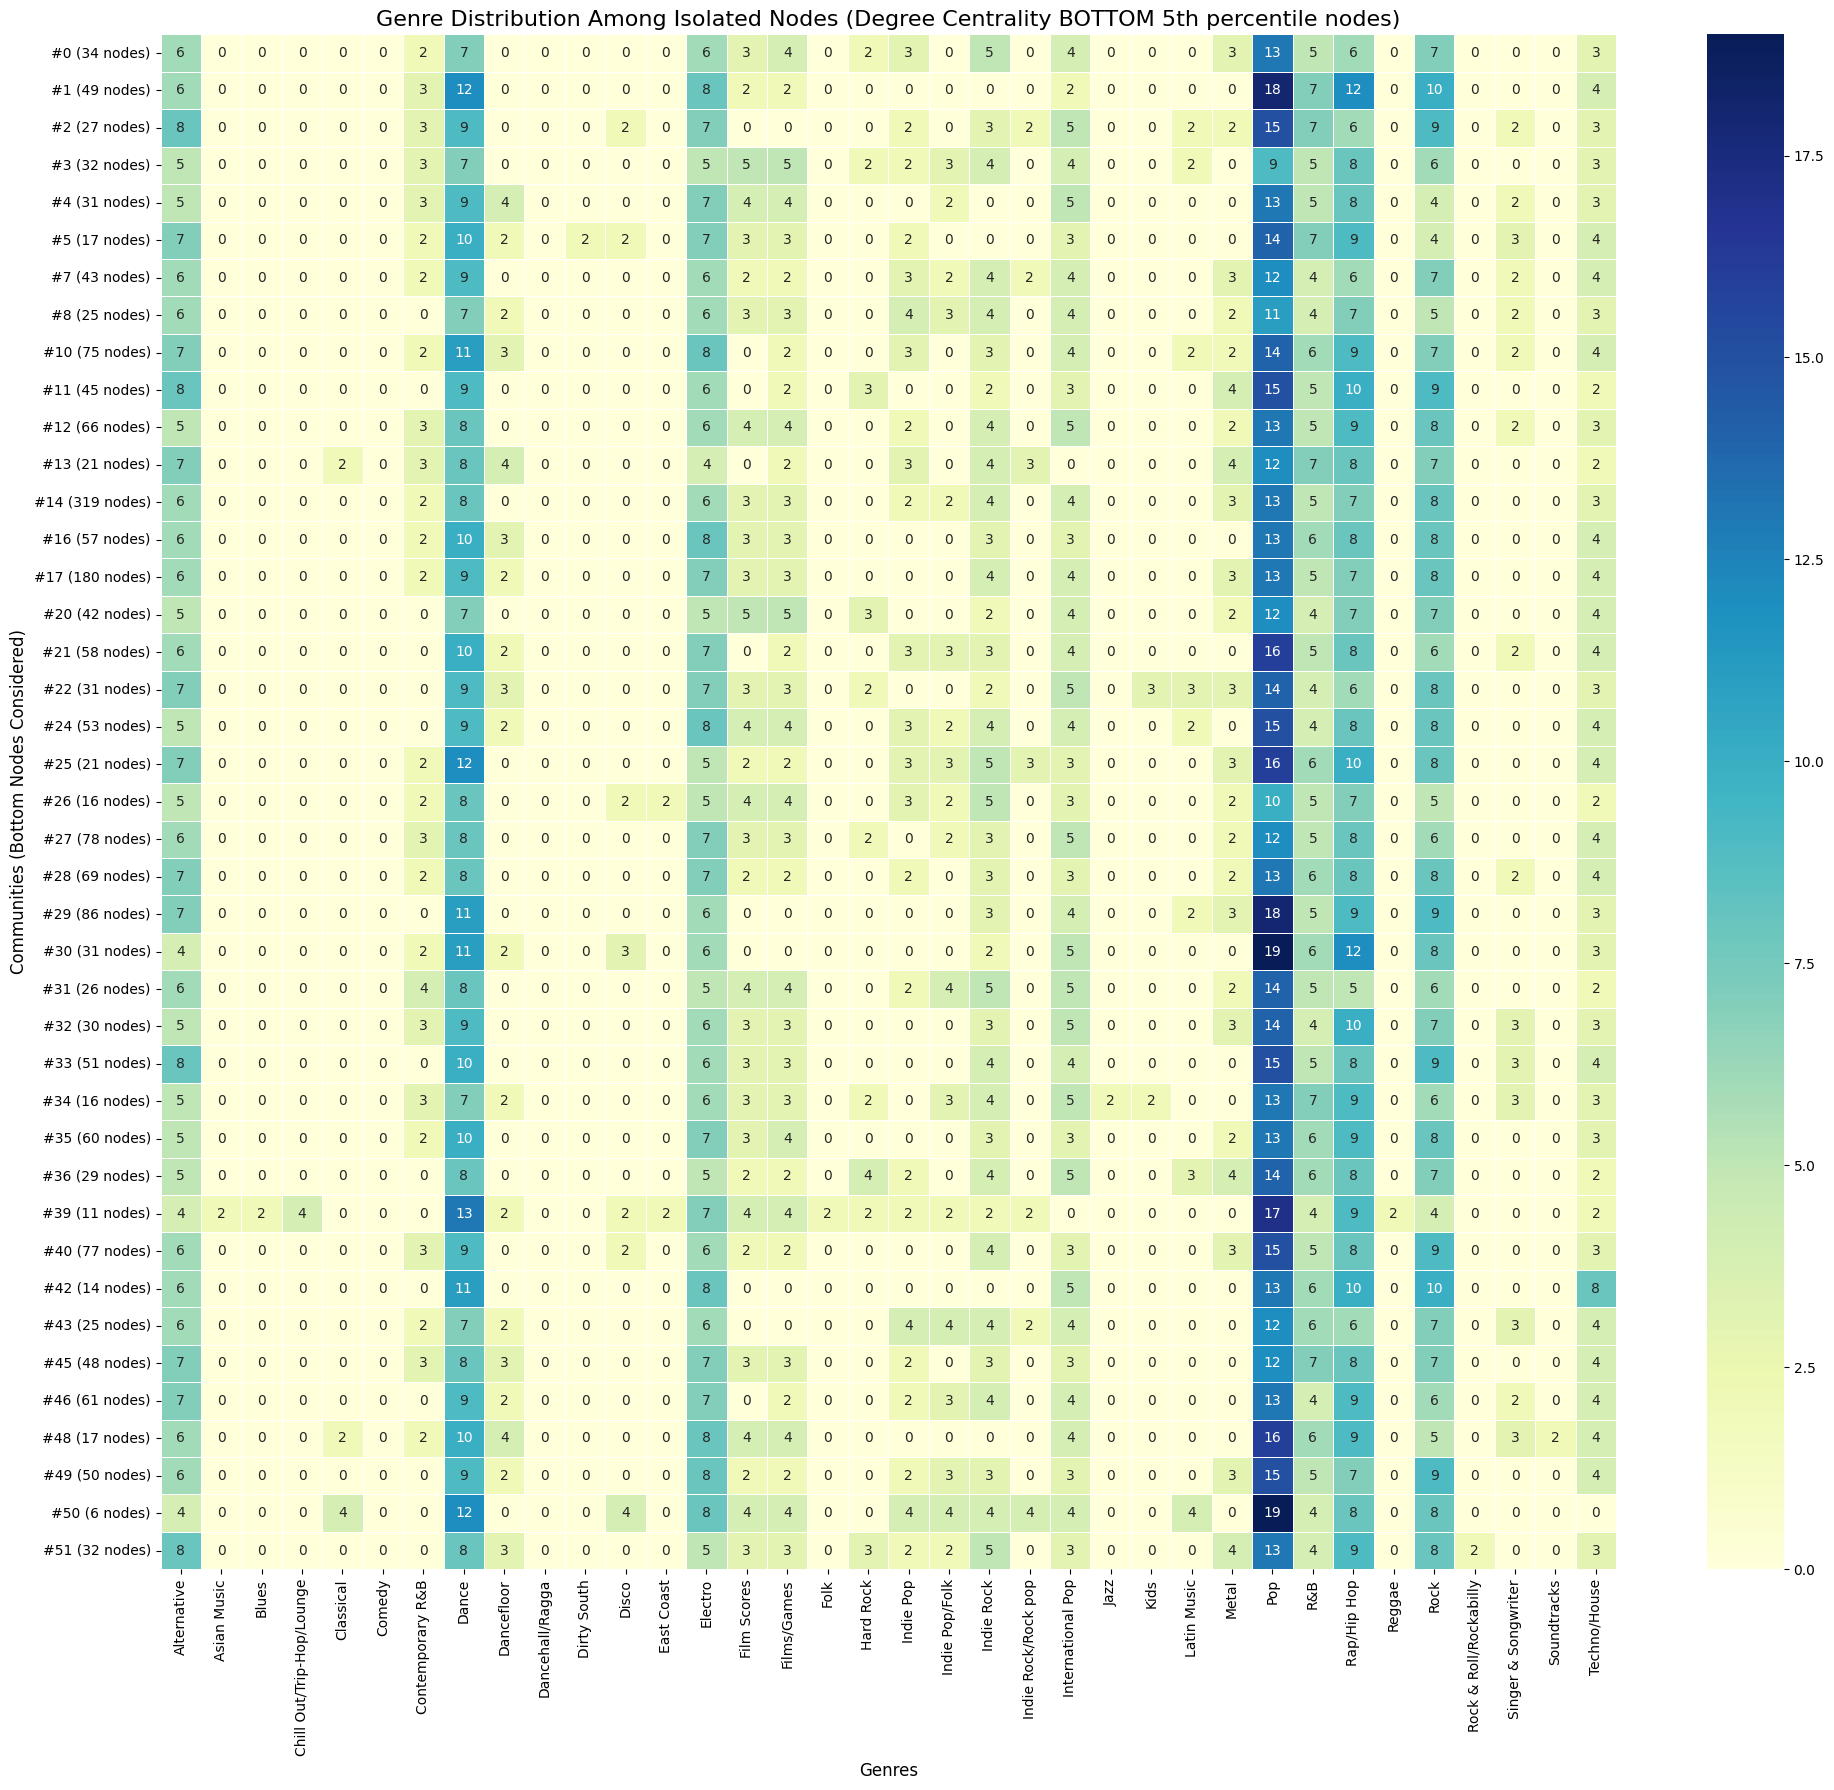

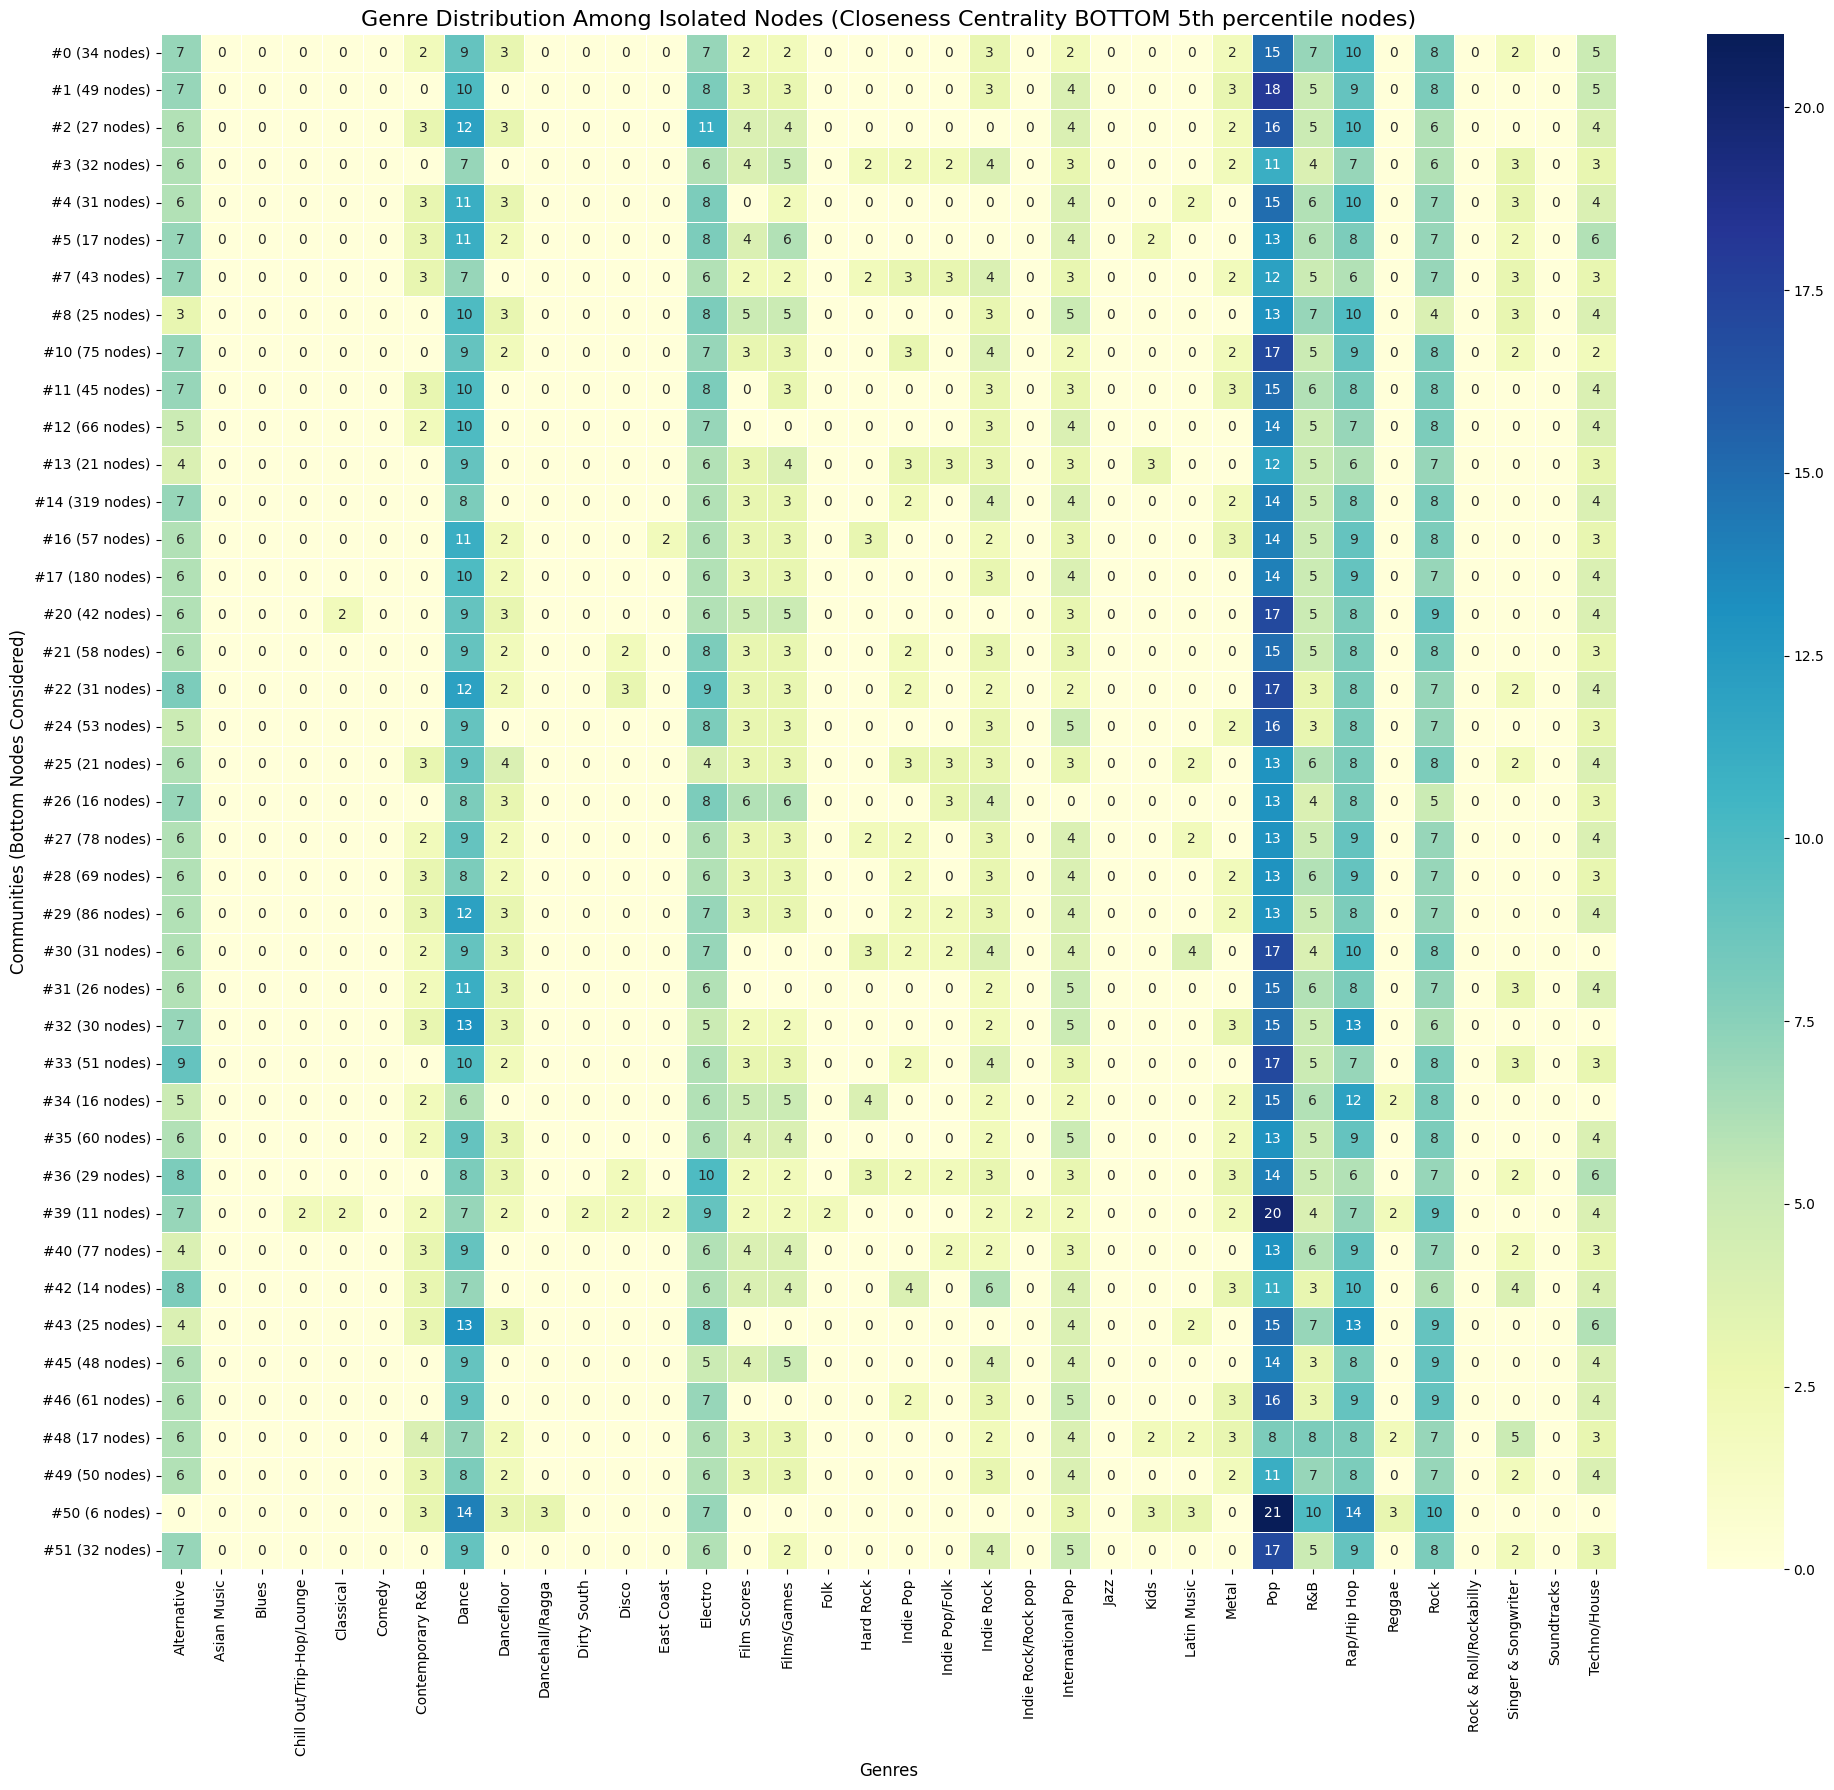

In [16]:
#@title Genre Distribution Among Isolated Nodes for Different Centrality Measures
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Define the percentile cutoff (bottom 5%)
percentile_cutoff = 0.05
min_percentage_threshold = 2  # Minimum percentage to display

# Group nodes by community
grouped = df_nodes.groupby('community_id')

# Initialize a dictionary to store results
isolation_genre_aggregation = {"betweenness": {}, "degree": {}, "closeness": {}}

for community_id, group in grouped:
    community_size = group['community_size'].iloc[0]  # Community size is constant within each group

    # Determine the cutoff for bottom percentile nodes
    bottom_percentile_count = max(1, int(len(group) * percentile_cutoff))

    # Skip communities with fewer than 2 nodes in the bottom percentile
    if bottom_percentile_count < 2:
        continue

    # Sort by each centrality measure
    sorted_by_betweenness = group.sort_values(by='betweenness_centrality', ascending=True)
    sorted_by_degree = group.sort_values(by='degree_centrality', ascending=True)
    sorted_by_closeness = group.sort_values(by='closeness_centrality', ascending=True)

    # Select bottom percentile nodes for each centrality measure
    bottom_betweenness = sorted_by_betweenness.head(bottom_percentile_count)
    bottom_degree = sorted_by_degree.head(bottom_percentile_count)
    bottom_closeness = sorted_by_closeness.head(bottom_percentile_count)

    # Aggregate genres for each centrality measure
    for measure, bottom_nodes in [("betweenness", bottom_betweenness), ("degree", bottom_degree), ("closeness", bottom_closeness)]:
        genres = [genre for genres in bottom_nodes['genres'] for genre in eval(genres)]
        genre_count = Counter(genres)
        total_genres = sum(genre_count.values())
        genre_percentage = {
            genre: (count / total_genres) * 100
            for genre, count in genre_count.items()
            if (count / total_genres) * 100 >= min_percentage_threshold  # Apply minimum percentage filter
        }
        isolation_genre_aggregation[measure][f"#{community_id} ({bottom_percentile_count} nodes)"] = genre_percentage

# Get the union of all genres for consistent ordering
all_genres = set()
for measure, communities in isolation_genre_aggregation.items():
    for genre_percentages in communities.values():
        all_genres.update(genre_percentages.keys())

# Sort genres alphabetically
sorted_genres = sorted(all_genres)

# Convert results into DataFrames for heatmaps
heatmap_data = {}
for measure, communities in isolation_genre_aggregation.items():
    rows = []
    for community_id, genre_percentages in communities.items():
        row = {"Community": community_id}
        row.update({genre: round(genre_percentages.get(genre, 0)) for genre in sorted_genres})  # Use sorted genres
        rows.append(row)
    df = pd.DataFrame(rows).fillna(0).set_index("Community")
    heatmap_data[measure] = df

# Plot heatmaps for each centrality measure
for measure, heatmap_df in heatmap_data.items():
    plt.figure(figsize=(20, 18))  # Larger horizontal size
    sns.heatmap(
        heatmap_df,
        cmap="YlGnBu",
        annot=True,
        fmt=".0f",
        linewidths=0.5,
        cbar=True
    )
    plt.title(f"Genre Distribution Among Isolated Nodes ({measure.capitalize()} Centrality BOTTOM 5th percentile nodes)", fontsize=16)
    plt.xlabel("Genres", fontsize=12)
    plt.ylabel("Communities (Bottom Nodes Considered)", fontsize=12)
    plt.tight_layout()
    plt.show()


## Insights

### Betweenness

The prevalence of genres like Pop, Dance, and Rap/Hip Hop among isolated nodes suggests that even users with low connectivity (low betweenness centrality) align with the broader network's most popular genres.
This aligns with the idea that popular genres percolate throughout the network, even to less connected users.

It might also indicate that the user interest in specific genres does not have significant impact on the friendship formations.

### Degree

Despite their low degree centrality, isolated nodes still favor popular genres like Pop, Dance, and Rap/Hip Hop, indicating these genres' ability to connect users with varying levels of centrality.

Compared to the genre distribution of nodes from the top 5th percentile, isolated node distributions appears to be much more heterogenous, with more niche-genres contributing to the overall isolation picture.

### Closeness

Despite their isolation, nodes with low closeness centrality still align with the community-wide popularity of Pop, Dance, and Rap/Hip Hop, suggesting these genres' reach across different levels of centrality.
